In [7]:
import os, re, glob, pathlib, csv
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Failide leidmine
# Kaust "data"
DATA_DIR = "data"  

csv_paths = sorted(

glob.glob(os.path.join(DATA_DIR, "Capture*.csv")),
    # Sorteerime Capture1..Capture10 numbrilise osa järgi (mitte tähestiku järgi)
key=lambda p: int(re.search(r"Capture(\d+)\.csv", os.path.basename(p)).group(1))
)

print("Leitud CSV-faile:", len(csv_paths))
csv_paths

Leitud CSV-faile: 10


['data/Capture1.csv',
 'data/Capture2.csv',
 'data/Capture3.csv',
 'data/Capture4.csv',
 'data/Capture5.csv',
 'data/Capture6.csv',
 'data/Capture7.csv',
 'data/Capture8.csv',
 'data/Capture9.csv',
 'data/Capture10.csv']

In [9]:
# Kiirkontroll csv-le
# esimese faili 3 rida, et näha päist ja eraldajat (',' või ';').
p = csv_paths[0]
with open(p, "r", encoding="utf-8", errors="ignore") as f:
    for _ in range(3):
        print(f.readline().rstrip("\n"))

event_id,i,dt_us,adc_raw,volts
2,0,613,330,0.2659
2,1,687,335,0.2700


In [10]:
# CSV lugemine
# Loeme ühe Capture faili mällu ja filtreerime välja mittesobivad read.
def detect_delimiter(sample_line: str) -> str:
    return ";" if sample_line.count(";") > sample_line.count(",") else ","

def read_capture_csv(path):
    dt_us, adc_raw, volts = [], [], []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first = f.readline().strip()
        delim = detect_delimiter(first)
        f.seek(0)

        has_header = ("event_id" in first) or ("dt_us" in first) or ("volts" in first)
        # Kui failil on päis, loeme DictReaderiga (veerunimedest sõltumata).

        if has_header:
            reader = csv.DictReader(f, delimiter=delim)
            for row in reader:
                ev = row.get("event_id", "")
                if ev is None or (not str(ev).strip().isdigit()):
                    # Jätame vahele markerread (nt END_EVENT) ja vigased read
                    continue
                try:
                    dt_us.append(float(row.get("dt_us", "")))
                    adc_raw.append(float(row.get("adc_raw", "")))
                    volts.append(float(row.get("volts", "")))
                except:
                    continue
        else:
            # eeldame: event_id,i,dt_us,adc_raw,volts
            reader = csv.reader(f, delimiter=delim)
            for row in reader:
                if not row:
                    continue
                ev = row[0].strip() if len(row) > 0 else ""
                if not ev.isdigit():
                    continue
                try:
                    dt_us.append(float(row[2]))
                    adc_raw.append(float(row[3]))
                    volts.append(float(row[4]))
                except:
                    continue

    dt_us = np.array(dt_us, dtype=float)
    adc_raw = np.array(adc_raw, dtype=float)
    volts = np.array(volts, dtype=float)
    t_s = dt_us / 1e6

    # Tagastame numpy massiivid: aeg sekundites, aeg mikrosekundites, ADC lugem ja pinge
    return {"t_s": t_s, "dt_us": dt_us, "adc_raw": adc_raw, "volts": volts}

In [11]:
# Laeme kõik 10 mõõtmist mällu
# Kvaliteedikontroll: trükime punktide arvu iga faili kohta.
captures = {}
for p in csv_paths:
    name = pathlib.Path(p).stem
    captures[name] = read_capture_csv(p)

print("Laetud:", len(captures))
for k in sorted(captures.keys()):
    print(k, "punkte:", len(captures[k]["dt_us"]))

Laetud: 10
Capture1 punkte: 10005
Capture10 punkte: 10003
Capture2 punkte: 10003
Capture3 punkte: 10002
Capture4 punkte: 10005
Capture5 punkte: 10005
Capture6 punkte: 10004
Capture7 punkte: 10005
Capture8 punkte: 10003
Capture9 punkte: 10006


In [12]:
name0 = sorted(captures.keys())[0]
d0 = captures[name0]
print("Näidis:", name0)
print("dt_us:", d0["dt_us"][:5])
print("volts:", d0["volts"][:5])

Näidis: Capture1
dt_us: [ 613.  687. 1000. 1500. 2000.]
volts: [0.2659 0.27   0.3796 0.2788 0.2595]


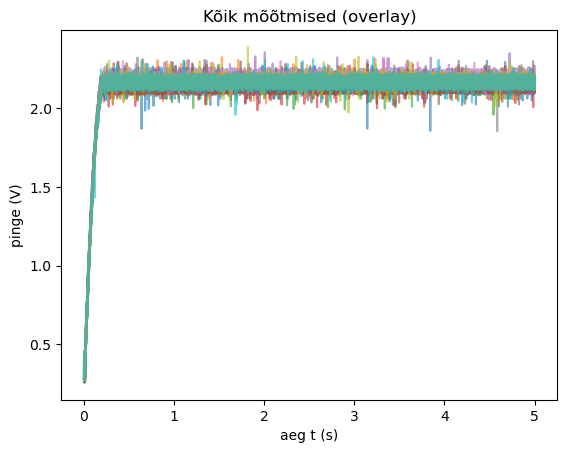

In [13]:
# Visuaalne kontroll (overlay)
# Kõik mõõtmised ühel graafikul, kiire sanity-check.
plt.figure()
for name in sorted(captures.keys()):
    d = captures[name]
    idx = np.argsort(d["t_s"])
    plt.plot(d["t_s"][idx], d["volts"][idx], alpha=0.6)

plt.xlabel("aeg t (s)")
plt.ylabel("pinge (V)")
plt.title("Kõik mõõtmised (overlay)")
plt.show()

In [14]:
# Ajaresolutsioon (Δt) ja jitter 
# Arvutame sämplingusammu statistika üle kõikide capture'ite.
# Ajaresolutsioon (Δt)

all_steps = []


for name, d in captures.items():
    dt = d["dt_us"]
    if len(dt) < 2:
        continue
    dt_sorted = np.sort(dt)
    steps = np.diff(dt_sorted)  # µs: järjestikuste proovide vahe  # µs
    steps = steps[np.isfinite(steps)]  # eemaldame NaN/inf
    steps = steps[steps > 0]  # kaitse: negatiivseid/0 samme ei tohiks olla
    if len(steps) > 0:
        all_steps.append(steps)

if len(all_steps) == 0:
    raise ValueError("Δt arvutamiseks pole ühtegi mõõtmist (kontrolli, kas dt_us loetakse).")

steps = np.concatenate(all_steps)

overall = {
    "median_us": float(np.median(steps)),
    "mean_us": float(np.mean(steps)),
    "std_us": float(np.std(steps, ddof=1)),
    "p1_us": float(np.percentile(steps, 1)),
    "p99_us": float(np.percentile(steps, 99)),
    "min_us": float(np.min(steps)),
    "max_us": float(np.max(steps)),
    "pct_gt_600": float((steps > 600).mean() * 100),
    "pct_lt_400": float((steps < 400).mean() * 100),
}

overall


{'median_us': 500.0,
 'mean_us': 499.9156161589907,
 'std_us': 27.903580849287366,
 'p1_us': 446.0,
 'p99_us': 554.0,
 'min_us': 42.0,
 'max_us': 2138.0,
 'pct_gt_600': 0.19693894892583297,
 'pct_lt_400': 0.26391818536253764}

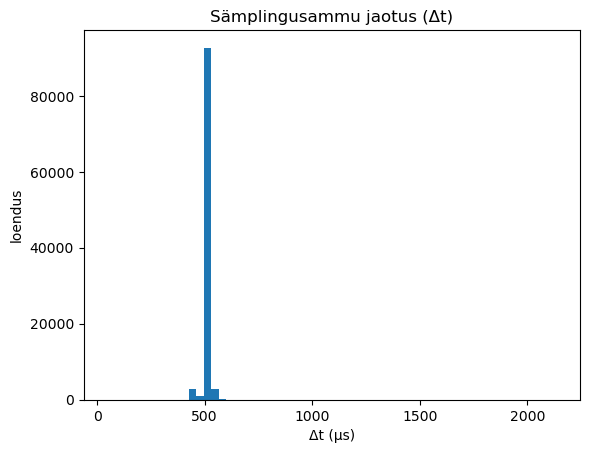

In [15]:
# Δt jaotus (jitteri visuaal) 
# Δt histogram
plt.figure()
plt.hist(steps, bins=60)
plt.xlabel("Δt (µs)")
plt.ylabel("loendus")
plt.title("Sämplingusammu jaotus (Δt)")
plt.show()

In [16]:
# ADC amplituudiresolutsioon (LSB) 
# Sobitame volts ≈ k*adc_raw + b ja võtame k põhjal LSB (mV/LSB).
# ADC teisendus ja LSB (volts ≈ k*adc_raw + b)
fits = []
for name, d in captures.items():
    x = d["adc_raw"]
    y = d["volts"]
    if len(x) < 2:
        continue
    A = np.vstack([x, np.ones_like(x)]).T  # y ≈ k*x + b
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]  # least-squares sobitus
    fits.append((name, float(k), float(b)))

k_vals = np.array([r[1] for r in fits], dtype=float)

summary_lsb = {
    "k_median_V_per_count": float(np.median(k_vals)),
    "k_mean_V_per_count": float(np.mean(k_vals)),
    "k_std_V_per_count": float(np.std(k_vals, ddof=1)),
    "LSB_mV": float(np.median(k_vals) * 1000),
}

summary_lsb

{'k_median_V_per_count': 0.00080585947688207,
 'k_mean_V_per_count': 0.0008058596821531774,
 'k_std_V_per_count': 1.5594198234355195e-09,
 'LSB_mV': 0.8058594768820699}

In [17]:
# Tunnused t10 ja t90 (praktiline ajaresolutsioon)
# Leiame ajad, mil signaal ületab 10% ja 90% amplituudist.
# t10/t90 tunnused ja korduvus

def feature_times(t, v, baseline_window_s=0.002):
    idx = np.argsort(t)
    t = t[idx]
    v = v[idx]

    mask = t <= baseline_window_s  # baseline akna valik
    if np.sum(mask) < 5:
        mask = np.arange(len(v)) < min(20, len(v))

    v0 = float(np.mean(v[mask]))  # baseline tase
    v_peak = float(np.max(v))  # tipuväärtus
    amp = v_peak - v0  # amplituud

    thr10 = v0 + 0.10 * amp
    thr90 = v0 + 0.90 * amp

    t10 = float(t[np.argmax(v >= thr10)]) if np.any(v >= thr10) else float("nan")
    t90 = float(t[np.argmax(v >= thr90)]) if np.any(v >= thr90) else float("nan")
    return t10, t90

features = []
for name, d in captures.items():
    t10, t90 = feature_times(d["t_s"], d["volts"], baseline_window_s=0.002)
    features.append((name, t10, t90))

t10 = np.array([r[1] for r in features], dtype=float)
t90 = np.array([r[2] for r in features], dtype=float)

summary_t = {
    "t10_mean_ms": float(np.mean(t10) * 1000),
    "t10_std_ms": float(np.std(t10, ddof=1) * 1000),
    "t90_mean_ms": float(np.mean(t90) * 1000),
    "t90_std_ms": float(np.std(t90, ddof=1) * 1000),
    "t90_min_ms": float(np.min(t90) * 1000),
    "t90_max_ms": float(np.max(t90) * 1000),
}

summary_t

{'t10_mean_ms': 18.3003,
 't10_std_ms': 2.6996131842255555,
 't90_mean_ms': 180.45019999999997,
 't90_std_ms': 11.243404000173213,
 't90_min_ms': 169.0,
 't90_max_ms': 203.5}

In [18]:
# Mürapõrand ja 3σ eristatavus
# Arvutame platoo aknas (vaikimisi 4.5…5.0 s) signaali std (σ) ja 3σ.
# Platoo-müra ja efektiivne resolutsioon (3σ)

def plateau_noise(t, v, tmin=4.5, tmax=5.0):
    idx = np.argsort(t)
    t = t[idx]
    v = v[idx]
    mask = (t >= tmin) & (t <= tmax)
    if np.sum(mask) < 10:
        return float("nan"), float("nan"), int(np.sum(mask))
    return float(np.mean(v[mask])), float(np.std(v[mask], ddof=1)), int(np.sum(mask))

plateau = []
for name, d in captures.items():
    m, s, n = plateau_noise(d["t_s"], d["volts"], 4.5, 5.0)
    plateau.append((name, m, s, n))

sigma_vals = np.array([r[2] for r in plateau if np.isfinite(r[2])], dtype=float)
k_med = float(np.median(k_vals))

summary_noise = {
    "plateau_sigma_V_mean": float(np.mean(sigma_vals)),
    "plateau_sigma_V_std": float(np.std(sigma_vals, ddof=1)),
    "plateau_3sigma_V_mean": float(np.mean(sigma_vals) * 3),
    "plateau_3sigma_counts_mean": float((np.mean(sigma_vals) * 3) / k_med),
    "adc_LSB_mV": float(k_med * 1000),
}

summary_noise

{'plateau_sigma_V_mean': 0.025993543853174754,
 'plateau_sigma_V_std': 0.0017150470233609002,
 'plateau_3sigma_V_mean': 0.07798063155952425,
 'plateau_3sigma_counts_mean': 96.76703419960648,
 'adc_LSB_mV': 0.8058594768820699}

In [19]:
def print_table(title, d):
    print("\n" + title)
    print("-" * len(title))
    for k, v in d.items():
        print(f"{k:25s} : {v}")

print_table("Ajaresolutsioon (Δt)", overall)
print_table("Pingeresolutsioon (ADC)", summary_lsb)
print_table("Tunnuste korduvus (t10/t90)", summary_t)
print_table("Mürapõrand ja efektiivne resolutsioon", summary_noise)


Ajaresolutsioon (Δt)
--------------------
median_us                 : 500.0
mean_us                   : 499.9156161589907
std_us                    : 27.903580849287366
p1_us                     : 446.0
p99_us                    : 554.0
min_us                    : 42.0
max_us                    : 2138.0
pct_gt_600                : 0.19693894892583297
pct_lt_400                : 0.26391818536253764

Pingeresolutsioon (ADC)
-----------------------
k_median_V_per_count      : 0.00080585947688207
k_mean_V_per_count        : 0.0008058596821531774
k_std_V_per_count         : 1.5594198234355195e-09
LSB_mV                    : 0.8058594768820699

Tunnuste korduvus (t10/t90)
---------------------------
t10_mean_ms               : 18.3003
t10_std_ms                : 2.6996131842255555
t90_mean_ms               : 180.45019999999997
t90_std_ms                : 11.243404000173213
t90_min_ms                : 169.0
t90_max_ms                : 203.5

Mürapõrand ja efektiivne resolutsioon
------------